<a href="https://colab.research.google.com/github/annvorosh/GB/blob/PyTorch/PyT_04_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Обучите CNN (самописная) на CIFAR-100.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor, Normalize, Compose


In [12]:
# Определение архитектуры CNN
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(1024, 100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [13]:
# Загрузка и предобработка данных
transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_data = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR100(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

# Определение оптимизатора и функции потерь
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [14]:
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
             ReLU-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

In [15]:
# Обучение модели

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(25):
    # Обнуление накопленных градиентов
    train_loss = 0
    correct = 0
    total = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Вывод результатов обучения для текущей эпохе
    print("Epoch: {}, Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(epoch+1, train_loss/len(train_loader), 100.*correct/total))
    
    train_losses.append(train_loss/len(train_loader))
    train_acc.append((100.*correct/total))

    # Оценка точности на тестовых данных
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Вывод результатов оценки точности на тестовых данных для текущей эпохи
    print("Epoch: {}, Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(epoch+1, test_loss/len(test_loader), 100.*correct/total))
    


    # Сохранение значения функции потерь и точности в списки для дальнейшей визуализации

    test_losses.append(test_loss/len(test_loader))
    test_acc.append((100.*correct/total))


Epoch: 1, Training Loss: 4.411, Training Accuracy: 3.920
Epoch: 1, Test Loss: 3.966, Test Accuracy: 7.680
Epoch: 2, Training Loss: 4.129, Training Accuracy: 5.682
Epoch: 2, Test Loss: 3.816, Test Accuracy: 10.490
Epoch: 3, Training Loss: 3.943, Training Accuracy: 8.082
Epoch: 3, Test Loss: 3.529, Test Accuracy: 16.010
Epoch: 4, Training Loss: 3.763, Training Accuracy: 10.340
Epoch: 4, Test Loss: 3.350, Test Accuracy: 19.560
Epoch: 5, Training Loss: 3.600, Training Accuracy: 12.662
Epoch: 5, Test Loss: 3.161, Test Accuracy: 22.410
Epoch: 6, Training Loss: 3.455, Training Accuracy: 14.838
Epoch: 6, Test Loss: 2.959, Test Accuracy: 26.640
Epoch: 7, Training Loss: 3.291, Training Accuracy: 17.800
Epoch: 7, Test Loss: 2.809, Test Accuracy: 29.740
Epoch: 8, Training Loss: 3.133, Training Accuracy: 20.416
Epoch: 8, Test Loss: 2.633, Test Accuracy: 32.370
Epoch: 9, Training Loss: 2.992, Training Accuracy: 22.686
Epoch: 9, Test Loss: 2.561, Test Accuracy: 33.930
Epoch: 10, Training Loss: 2.846,

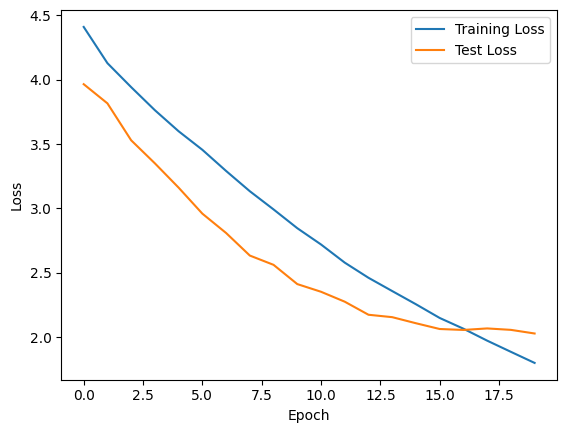

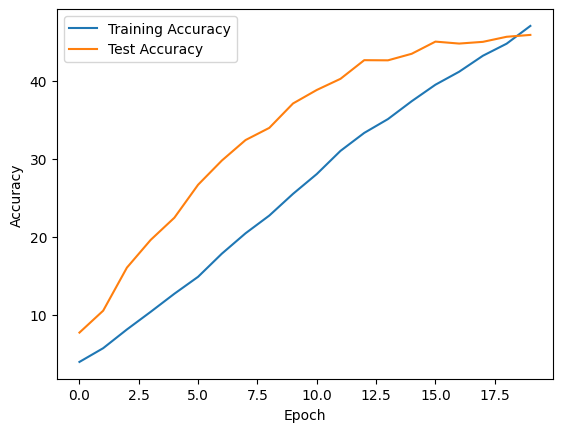

In [16]:
import matplotlib.pyplot as plt

# Построение графика функции потерь на обучающих и тестовых данных
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Построение графика точности на обучающих и тестовых данных
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

3. * Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchvision.models import resnet50
import matplotlib.pyplot as plt

In [19]:
# Загрузка модели
resnet = resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 100)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:

# Загрузка данных
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001, 
                      #  momentum=0.9
                       )


In [22]:
# Обучение сети
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(15):  # 15 эпох

    # Обучение
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # Прямой проход
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Статистика обучения
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = train_running_loss
    train_losses.append(train_epoch_loss)
    train_acc = train_correct / train_total
    train_accs.append(train_acc)

    # Тестирование
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Прямой проход
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            # Статистика тестирования
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_epoch_loss = test_running_loss
    test_losses.append(test_epoch_loss)
    test_acc = test_correct / test_total
    test_accs.append(test_acc)

    # Вывод статистики
    print('Epoch [{}/{}], Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, 15, train_epoch_loss, train_acc, test_acc))

Epoch [1/15], Loss: 1239.0036, Train Acc: 0.2324, Test Acc: 0.3575
Epoch [2/15], Loss: 986.1908, Train Acc: 0.3511, Test Acc: 0.3944
Epoch [3/15], Loss: 830.3667, Train Acc: 0.4300, Test Acc: 0.4681
Epoch [4/15], Loss: 736.9814, Train Acc: 0.4825, Test Acc: 0.4846
Epoch [5/15], Loss: 679.8013, Train Acc: 0.5165, Test Acc: 0.5011
Epoch [6/15], Loss: 630.5141, Train Acc: 0.5468, Test Acc: 0.5162
Epoch [7/15], Loss: 592.9401, Train Acc: 0.5693, Test Acc: 0.5446
Epoch [8/15], Loss: 551.9874, Train Acc: 0.5924, Test Acc: 0.5434
Epoch [9/15], Loss: 527.9988, Train Acc: 0.6100, Test Acc: 0.5480
Epoch [10/15], Loss: 503.8564, Train Acc: 0.6258, Test Acc: 0.5487
Epoch [11/15], Loss: 469.5770, Train Acc: 0.6450, Test Acc: 0.5586
Epoch [12/15], Loss: 463.8322, Train Acc: 0.6512, Test Acc: 0.5658
Epoch [13/15], Loss: 446.5884, Train Acc: 0.6639, Test Acc: 0.5571
Epoch [14/15], Loss: 414.5022, Train Acc: 0.6840, Test Acc: 0.5628
Epoch [15/15], Loss: 387.8970, Train Acc: 0.7010, Test Acc: 0.5632


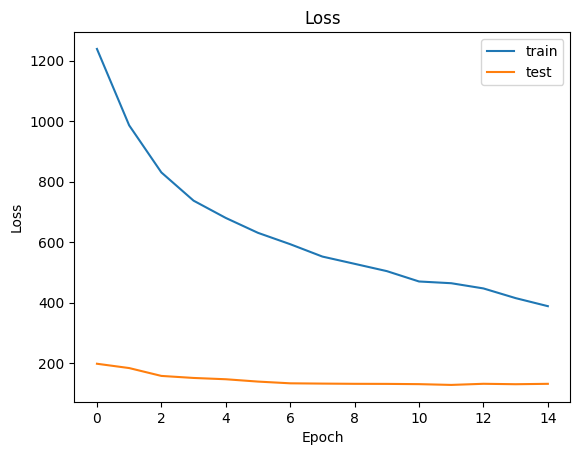

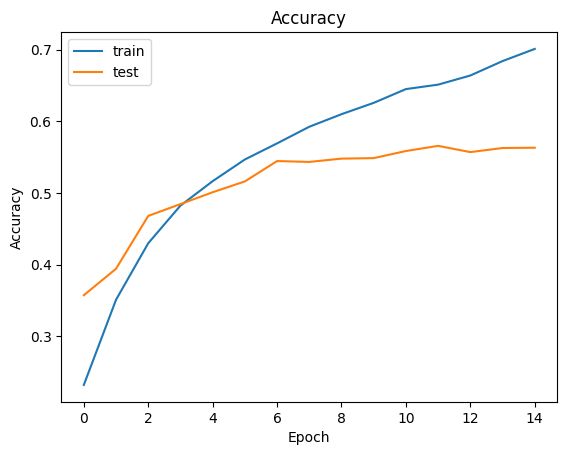

In [23]:
# График потерь на тренировочном и тестовом наборах данных
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности на тренировочном и тестовом наборах данных
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
